### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


#### __problema continuo__

Sea el problema bidimencional pulso gausiano rotatorio definido por la ecuacion: 
$$
\frac{\partial u}{\partial t} - 0.0001 \nabla  u + \nabla \cdot (w u)=0 \text{en} \  M=\Omega \times (0,T) 
$$

Donde $u(x,t) \in \mathbb{R}$ 
$$\Omega = {x \in \mathbb{R}^2 : x_i \in (-0.5,0.5), i=1,2 }$$
$$ w(x_1,X_2) = [-4x_2,4x_1] $$
Y
$$T= \frac{\pi}{2}$$

tenemos que la solución analitica del problema esta dada por la función: 

$$
u(x,t)=\frac{1.0}{1.0+0.1t}exp(-\frac{(\bar{x_1}+0.25)^2+ \bar{x_2}^2}{0.004})
$$

donde: 
$$
\bar{x_1}=x_1cos(4t)+x_2sin(4t) 
$$
$$
\bar{x_2}=-x_1 sin(4t)+x_2cos(4t) 
$$
Primero creamos una malla:

$$
\int_{\Omega} \frac{\partial(u)}{\partial(t)} *v +0.0001{\nabla(u) \cdot \nabla(v)}+\nabla \cdot (w*u)vdx = 0
$$

In [124]:
# Importaciones necesarias
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl

from mshr import *
start_code = time.time()
flag ="R"
parameters['linear_algebra_backend'] = 'Eigen'
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
def tran2SparseMatrix(A):
    row, col, val = as_backend_type(A).data()
    return sps.csr_matrix((val, col, row))
# mempool = cupy.get_default_memory_pool()

# with cupy.cuda.Device(0):
#     mempool.set_limit(size=4*1024**3)
    
#np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# Parámetros de simulación
T = math.pi/2            # Tiempo final
num_steps = 2# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo

# Creación de la malla y definición del espacio de funciones
nx = ny =20# Número de divisiones en x e y
#R=Rectangle(Point(-0.5,-0.5),Point(0.5,0.5))
#mesh=generate_mesh(R,64)
mesh = RectangleMesh(Point(-0.5,-0.5),Point(0.5,0.5),nx,ny)  # Crea una malla cuadrada unitaria
V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
V_vec = VectorFunctionSpace(mesh, 'CG',2)


w =Expression(('-4*x[1]','4*x[0]'),degree=2)
w = interpolate(w,V_vec)
# Definición de la condición de frontera
u_o = Expression('exp(-(pow(x[0]+0.25,2)+pow(x[1],2))/(0.004))',
                 degree=2)  # Expresión para u_D

u_analytical=Expression('(1.0/(1.0+0.1*t))*exp(-(pow(x[0]*cos(4*t)+x[1]*sin(4*t)+0.25,2)+pow(-x[0]*sin(4*t)+x[1]*cos(4*t),2))/(0.004*(1+0.1*t)))',t=0,degree=1)
class MyExpression0(UserExpression):
    def __init__(self, t, **kwargs):
        super().__init__(**kwargs)
        self._t=t
    def eval(self, value, x,):
        x1_bar = x[0]*cos(4*self._t)+x[1]*sin(4*self._t)
        x2_bar = -x[0]*sin(4*self._t)+x[1]*cos(4*self._t)
        value[0] = (1.0/(1.0+0.1*self._t))*exp(-(pow(x1_bar+0.25,2)+pow(x2_bar,2))/(0.004*(1+0.1*self._t)))


# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V

# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test




K_fem =0.0001*dot(grad(u), grad(v))*dx +div(w*u)*v*dx  # Formulación débil
C_fem=u*v*dx
def fi (A,m,tau=1):
    d=scipy.sparse.identity(m)
    
    return (scipy.linalg.expm(tau*A)-d)*scipy.sparse.linalg.spsolve(tau*A,d)
# algoritmo de arnoldi 
def arnoldi_iteration_m(A, b, n):
    m = A.shape[0]
    h = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))
    beta= np.linalg.norm(b)
    q = b / beta
    Q[:, 0] = q
    print("beta on m ",beta)
    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        eps = 1e-12
        if h[k + 1, k] > eps:
            q = v / h[k + 1, k]
            Q[:, k + 1] = q
        else:
            return Q[:,0:n], h[0:n, 0:n]
    return Q[:,0:n], h
#h=np.pad(h, [(0, 1), (0, 1)], mode='constant', constant_values=0)
#Q=np.pad(Q, [(0, 0), (0, 1)], mode='constant', constant_values=0)
def arnoldi_iteration_error(A, b,tau):
    m = A.shape[0]
    beta= np.linalg.norm(b)
    tol=1E-4
    n=1
    error=1
    #print("beta on er",beta)
    while error > tol:
        n += 1
        e_m=np.zeros(n)
        e_m[n-1]=1
        e_1=np.zeros(n)
        e_1[0]=1
        h = np.zeros((n + 1, n))
        Q = np.zeros((m, n + 1))
        q = b / beta
        Q[:, 0] = q
        for k in range(n):
            v = A.dot(q)
            for j in range(k + 1):
                h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
                v = v - h[j, k] * Q[:, j]

            h[k + 1, k] = np.linalg.norm(v)
            q = v / h[k + 1, k]
            Q[:, k + 1] = q
        fi_m =fi(h[0:n, 0:n],n,tau)
        error = beta*abs(h[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
    print(f"H dim= {n} error = {error}")
    return Q[:,0:n], h[0:n, 0:n],fi_m,e_1,n 
        
def arnoldi_iteration(A, b,tau):
    m = A.shape[0]
    beta= np.linalg.norm(b)
    tol=1E-4
    n=2
    error=1
    #print("beta on er",beta)
    eta=1/sqrt(2)
    H = np.zeros((n + 1, n))
    V = np.zeros((m, n + 1))
    V[:, 0] = b / beta
    j=0
    while error >= tol:
        if n>2 :
            H=np.pad(H, [(0, 1), (0, 1)], mode='constant', constant_values=0)
            V=np.pad(V, [(0, 0), (0, 1)], mode='constant', constant_values=0)
        e_m=np.zeros(n)
        e_m[n-1]=1
        e_1=np.zeros(n)
        e_1[0]=1
        v = A.dot(V[:, j])
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i].conj(), v)  # <-- V needs conjugation!
            v = v - H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        V[:, j + 1] = v / H[j + 1, j]
        j += 1
        if n>2 or (n==2 and j==2):
            fi_m=fi(H[0:n, 0:n],n,tau)
            error = beta*abs(H[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
            n += 1
    print(f"H dim= {n} error = {error}")
    return V[:,0:n], H[0:n, 0:n],fi_m,e_1,n 
# proceso 
vtkfile_u = XDMFFile("results/u_exp.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

t= 0
u_=Function(V)


K= assemble(lhs(K_fem))# Separa la parte izquierda y derecha de la ecuación
#bc.apply(K)
K_=scipy.sparse.csr_matrix(K.array()) 
C=assemble(C_fem)
N_degree=C.array().shape[0]
#C_c = tran2SparseMatrix(C)
#C_c = cupyx.scipy.sparse.csr_matrix(C_c)
#bc.apply(C)


#I_np=np.identity(N_degree)
#I_cupy=cupyx.scipy.sparse.identity(N_degree)
# A1 = assemble(L)
# [bc.apply(A1) for bc in bcs]


# b1 = assemble(R)
# [bc.apply(b1) for bc in bcs]
# b1= b1[:]
# b1 = cupy.array(b1)
# X_w.vector()[:] = cupy.asnumpy(linalge.spsolve(A1, b1))
    
C=scipy.sparse.csc_matrix(C.array().astype(np.float32))
I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))

# 


start=time.time()
C_1=scipy.sparse.linalg.spsolve(C,I_n)
#C_1=np.linalg.solve(C.array(),I_np)
#C_1 = cupyx.scipy.sparse.linalg.spsolve(C_c, I_cupy)

A=-C_1.dot(K_)
m=9
v_hat=np.zeros(m)
v_hat[0]=1


u_n = interpolate(u_analytical, V)
u_i=u_n.vector().get_local()
start=time.time()
#V_m,H_m,fi_m,e_1,m= arnoldi_iteration_error(A,u_i,dt)
V_m,H_m,fi_m,e_1,m= arnoldi_iteration(A,u_i,dt)
end=time.time()
print(f"arnoldi time {end-start}")
# for n in range(num_steps):
#     t += dt
#     Beta=np.linalg.norm(u_i)
#     V_m,H_m,fi_m,e_1,m= arnoldi_iteration_error(A,u_i,dt)
#     u_i=Beta*np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),e_1.T)
#     #u_i=np.dot(scipy.linalg.expm(dt*A),u_i)
#     u_.vector()[:]=u_i
#     print(f'step:{n+1} of {num_steps} time= {t} \n tamaño m  ={m}')
#     u_.rename("u_a", "u_a");vtkfile_u.write(u_, t)
# end_code = time.time()
# print(f" total execution time = {end_code-start_code}")

H dim= 82 error = 7.987329250540714e-05
arnoldi time 1.3141136169433594


In [101]:
H_m[0,2]

0.5438256063941868

Calling FFC just-in-time (JIT) compiler, this may take some time.
60.751090601760914


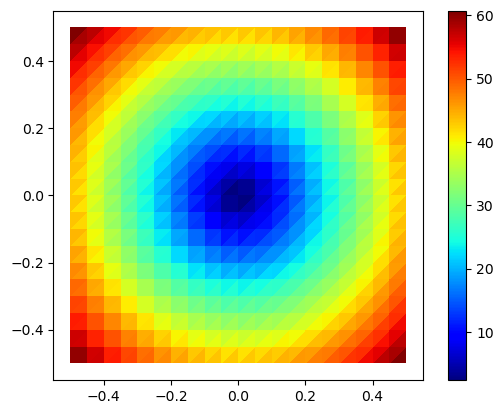

In [11]:
# Cell size and timestep
h = CellDiameter(mesh)

# Compute the CFL number cell wise
DG = FunctionSpace(mesh, "DG", 0)
CFL = project(2*sqrt(inner(w,w))*dt/h, DG)
print(CFL.vector().max())
p=plot(CFL)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

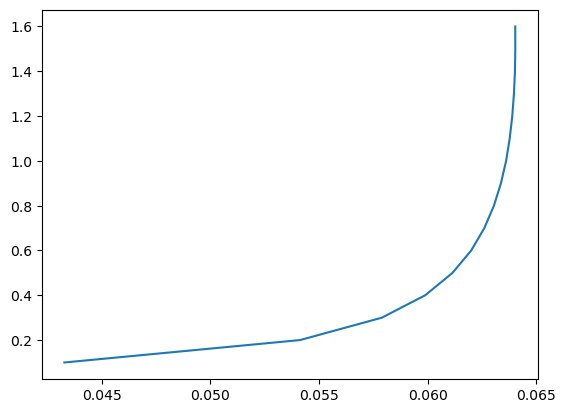

In [22]:
import pandas as pd

df1 = pd.read_csv(f'results_dt_{0.1}/error_scheme_{'BDF1'}.csv')

df2 = pd.concat([df1,df1['BDF1']],axis=1)

plt.plot(df1['BDF1'],df1['tiempo'])

In [7]:
V_m_e,H_m_e = arnoldi_iteration_m(A,u_i,3)
H_m_e

NameError: name 'arnoldi_iteration_m' is not defined

In [8]:
m = A.shape[0]

h = np.zeros((n + 1, n))
Q = np.zeros((m, n + 1))

Q[:, 0] = q
for k in range(n):
    v = A.dot(q)
    for j in range(k + 1):
        h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
        v = v - h[j, k] * Q[:, j]

    h[k + 1, k] = np.linalg.norm(v)
    eps = 1e-12
    if h[k + 1, k] > eps:
        q = v / h[k + 1, k]
        Q[:, k + 1] = q
    else:
        return Q[:,0:n], h[0:n, 0:n]
return Q[:,0:n], h[0:n, 0:n]

NameError: name 'A' is not defined

In [35]:
a=np.array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.]])
a =np.pad(a, [(0, 0), (0, 1)], mode='constant', constant_values=0)
a

array([[ 1.00,  1.00,  1.00,  1.00,  1.00,  0.00],
       [ 1.00,  1.00,  1.00,  1.00,  1.00,  0.00],
       [ 1.00,  1.00,  1.00,  1.00,  1.00,  0.00]])

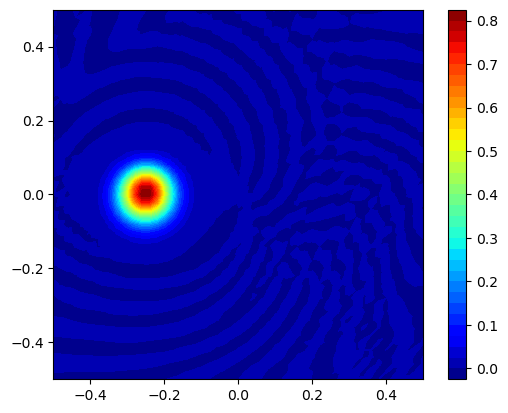

In [5]:

p=plot(u_)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

In [4]:
for i, cell in enumerate(cells(mesh)):
    if  cell.index() == 600:
        C_local= assemble_local(u*v*dx, cell)
        A= cell.volume()
        C_local=(C_local/A)*12
        break

In [5]:
C_local

array([[2., 1., 1.],
       [1., 2., 1.],
       [1., 1., 2.]])

In [6]:
cell.index()

600

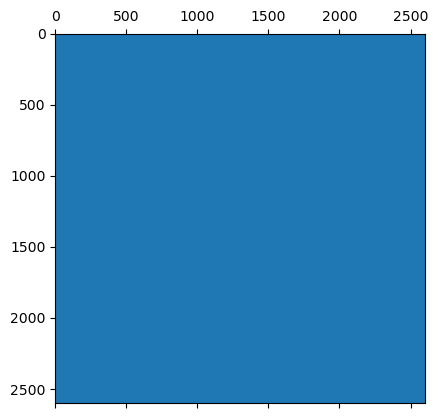

In [6]:
plt.spy(A)
plt.show()

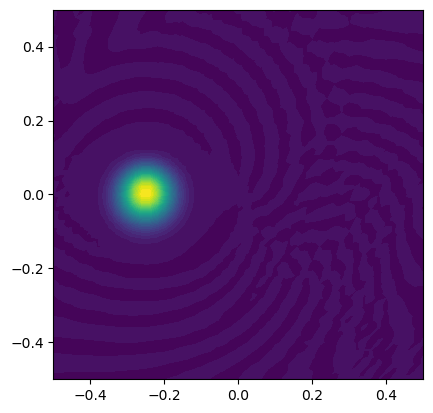

In [11]:
plot(u_)


3.957116348025008
3.9509345068523674
3.944781547429052
3.938657245559259
3.932561379476105
3.9264937298078952
3.920454079544973
3.9144422140071113
3.90845792081147
3.9025009898410814
3.896571213213856
3.890668385252123
3.8847923024526616
3.8789427634572293
3.873119569023585
3.8673225219969884
3.861551427282156
3.8558060918156936
3.8500863245389567
3.8443919363713746
3.8387227401841955
3.833078550774655
3.827459184840567
3.82186446095532
3.8162941995432726
3.8107482228555507
3.805226354946214
3.799728421648816
3.794254250553338
3.788803670983471
3.7833765139742686
3.7779726122501467
3.77259180020323
3.7672339138720377
3.7618987909204917
3.756586270617263
3.751296193815434
3.7460284029324797
3.7407827419305337
3.7355590562969914
3.7303571930253883
3.725177000596579
3.720018328960199
3.7148810295164068
3.7097649550979095
3.704669959952255
3.6995958997243874
3.694542631439472
3.689510013485967
3.6844979055989775


In [20]:
u_n = interpolate(u_analytical, V)
u_i=u_n.vector().get_local()
K= assemble(lhs(K_fem))# Separa la parte izquierda y derecha de la ecuación
K_=K.array()
C=assemble(C_fem)
C_1=np.linalg.inv(C.array())
A=C_1*K_

In [11]:
V_m.shape

(41, 8)

In [12]:
H_m.shape

(8, 8)

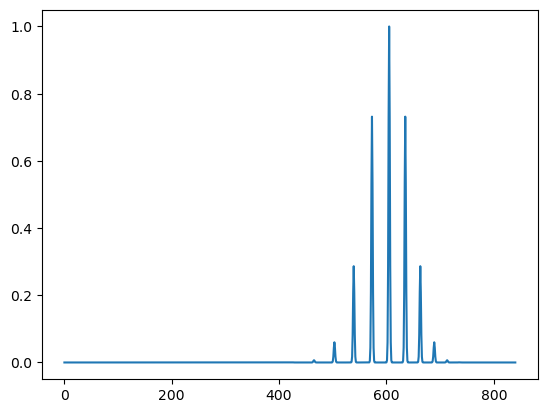

In [13]:
plt.plot(u_i)

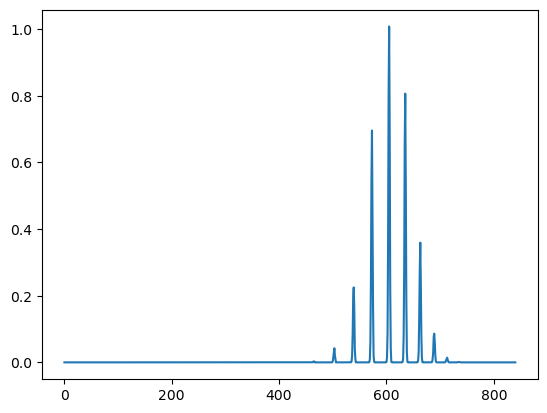

In [51]:
v_hat=np.array([1,0,0,0,0,0,0])
Beta=np.linalg.norm(u_i)
V_m,H_m = arnoldi_iteration_3(A,u_i,7)
u_i=Beta*np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),v_hat.T)
plt.plot(u_i)

In [54]:

Beta=np.linalg.norm(u_i)
V_m,H_m = arnoldi_iteration_3(A,u_i,8)
np.dot(np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),V_m.T),u_i)

NameError: name 'arnoldi_iteration' is not defined

In [16]:
u.vector()[:]=np.dot(scipy.linalg.expm(0.0001*A),u_i)

In [45]:
u[1,:].shape

(51521,)

In [11]:
# Importaciones necesarias
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import scipy
import time
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
start_code=time.time()
# Parámetros de simulación
T = math.pi/2            # Tiempo final
num_steps = 2000# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo

# Creación de la malla y definición del espacio de funciones
nx = ny = 80# Número de divisiones en x e y
mesh = RectangleMesh(Point(-0.5,-0.5),Point(0.5,0.5),nx,ny,"crossed")  # Crea una malla cuadrada unitaria
V = FunctionSpace(mesh, 'CG', 1) # Define el espacio de funciones con elementos lineales
V_vec = VectorFunctionSpace(mesh, 'CG',1)


w =Expression(('-4*x[1]','4*x[0]'),degree=2)
w = interpolate(w,V_vec)
# Definición de la condición de frontera
u_o = Expression('exp(-(pow(x[0]+0.25,2)+pow(x[1],2))/(0.004))',
                 degree=2)  # Expresión para u_D

u_analytical=Expression('(1.0/(1.0+0.1*t))*exp(-(pow(x[0]*cos(4*t)+x[1]*sin(4*t)+0.25,2)+pow(-x[0]*sin(4*t)+x[1]*cos(4*t),2))/(0.004*(1+0.1*t)))',t=0,degree=1)
class MyExpression0(UserExpression):
    def __init__(self, t, **kwargs):
        super().__init__(**kwargs)
        self._t=t
    def eval(self, value, x,):
        x1_bar = x[0]*cos(4*self._t)+x[1]*sin(4*self._t)
        x2_bar = -x[0]*sin(4*self._t)+x[1]*cos(4*self._t)
        value[0] = (1.0/(1.0+0.1*self._t))*exp(-(pow(x1_bar+0.25,2)+pow(x2_bar,2))/(0.004*(1+0.1*self._t)))


def boundary(x, on_boundary):
    return on_boundary  # Función que define la frontera

bc = DirichletBC(V, 0.0 , boundary)  # Aplica la condición de frontera de Dirichlet

# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V
u_nn = interpolate(u_o, V) 
u_nnn = interpolate(u_o, V) 
# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test

# Formulación del problema variacional
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
pconst= [11/6,-3,3/2,-1/3] #bdf 3
#pconst=[1,-1,0,0] #bdf1

du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn
t= 0
u_=Function(V)
vtkfile_ubdf = XDMFFile("results/u_BDF.xdmf")
vtkfile_ubdf.parameters["flush_output"] = True
vtkfile_ubdf.parameters["rewrite_function_mesh"] = False
F = du_t*v*dx + dt*0.0001*dot(grad(u), grad(v))*dx +dt*(div(w*u))*v*dx  # Formulación débil
a, L = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
for n in range(num_steps):

    # Actualizar el tiempo actual
    t += dt
    # Resolver la solución
    solve(a == L, u_)
    # Graficar la solución
    #print(f'step:{n} of {num_steps}')
    Beta=np.linalg.norm(u_.vector().get_local())
    #print(Beta)
    # Calcular el error
#     u_e = interpolate(u_D, V)  # Interpolar la solución exacta
#     error = np.abs(np.array(u_e.vector()) - np.array(u.vector())).max()  # Error máximo
#     print('t = %.2f: error = %.3g' % (t, error))

    # Actualizar la solución anterior
    u_nnn.assign(u_nn)
    u_nn.assign(u_n)
    u_n.assign(u_)
    if n%400==0:
        u_n.rename("u_a", "u_a");vtkfile_ubdf.write(u_n, t)
    
end_code = time.time()
print(f" total execution time = {end_code-start_code}")


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [1]:
p=plot(u_)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

NameError: name 'plot' is not defined